<a href="https://colab.research.google.com/github/larissensium/algo-trading-project/blob/main/copy_of_lo_imbalance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import packages

import scipy.io as sio  # for loading matlab data

import numpy as np      # for numerical libs

from matplotlib.ticker import FuncFormatter # for custom bar plot labels

import matplotlib.pyplot as plt  # for plotting

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
from statsmodels.tsa import stattools
from statsmodels.graphics import gofplots
from scipy import stats
from statsmodels.tsa import arima_model
from statsmodels.regression import linear_model

# load data

In [ ]:
data = sio.loadmat('MSFT_20141103.mat')
#data = sio.loadmat('MSFT_20141107.mat')
#data = sio.loadmat('GOOG_20141103.mat')

In [ ]:
LOB=data['LOB']

t = (np.array((LOB['EventTime'][0][0][:,0]))-3600000*9.5)*1e-3#time in seconds, measured from NASDAQ opening at 9:30am
bid = np.array(LOB['BuyPrice'][0][0]*1e-4)
bidvol = np.array(LOB['BuyVolume'][0][0]*1.0)
ask = np.array(LOB['SellPrice'][0][0]*1e-4)
askvol = np.array(LOB['SellVolume'][0][0]*1.0)
nMO = np.array(LOB['NumberMO'][0][0]*1.0)#total number of MOs submitted in the given 0.1 second interval
vMO = np.array(LOB['VolumeMO'][0][0]*1.0)#total volume of MOs submitted in the given 0.1 second interval
MO=np.array(LOB['MO'][0][0]*1.0)#information about market orders
dt = t[1]-t[0]
print(dt)
print(t[0:10])
print(len(t))
print(len(bid[:,0]))
print(t[-1])
tcur = 10*60*40

0.1
[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
234000
234000
23400.0


In [ ]:
#plot midprice and best bid/ask prices
midprice = 0.5*(bid[:,0]+ask[:,0])
spread = ask[:,0]-bid[:,0]

In [ ]:
#plot microprice
microprice= (bid[:,0]*askvol[:,0]+ask[:,0]*bidvol[:,0])/(bidvol[:,0]+askvol[:,0])

# LO Imbalance

In [ ]:
#compute LO imbalance for each time stamp
rho = np.array((bidvol[:,0]-askvol[:,0])/(bidvol[:,0]+askvol[:,0]),ndmin=2).T

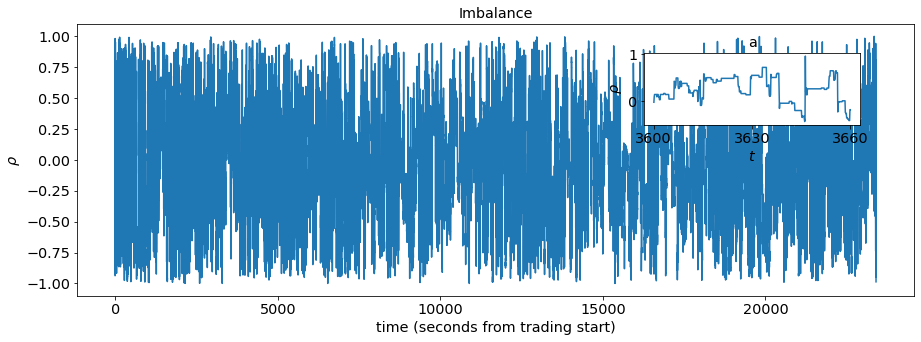

In [ ]:
#plot LO imbalance
plt.plot(t, rho)
plt.title('Imbalance')
plt.ylabel(r'$\rho$')
plt.xlabel('time (seconds from trading start)')

a = plt.axes([.65, .6, .2, .2])
idx = (t>3600) & (t<=3600+60)
plt.plot( t[idx], rho[idx])
plt.title('a')
plt.ylabel(r'$\rho$')
plt.xlabel(r'$t$')
plt.xticks([3600,3630,3660])

plt.show()

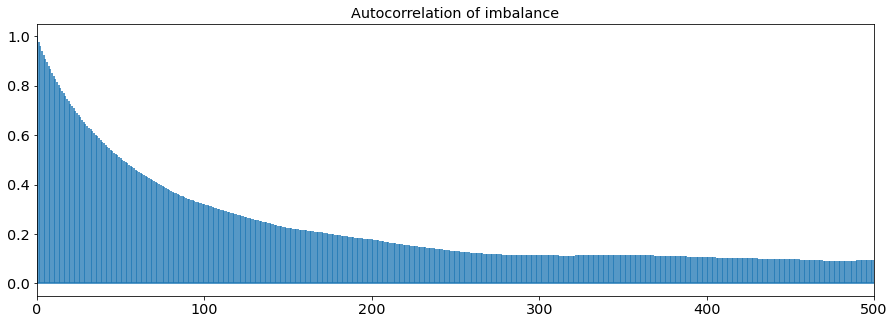

In [ ]:
#LO imbalance is not iid
plt.acorr(rho[:,0]-np.mean(rho[:,0]),maxlags=600)  # maximum one minute 
plt.title('Autocorrelation of imbalance')
plt.xlim([0,500])
plt.show()

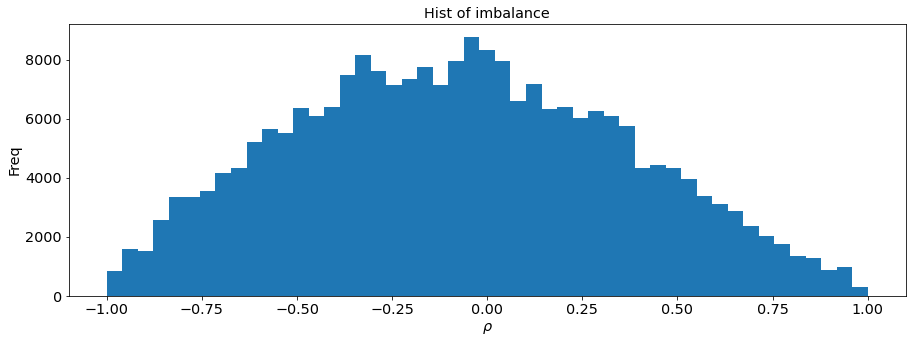

In [ ]:
#LO imbalance spends mote time around zero than around +-1
plt.hist(rho, bins=np.linspace(-1, 1, num=50)) 
plt.title("Hist of imbalance")
plt.xlabel(r'$\rho$')
plt.ylabel('Freq')
plt.show()

# LO Imbalance at times of Market Orders

In [ ]:
#compute LO imbalance at the arrival times of MOs
rho_MO = (MO[:,3]-MO[:,4])/(MO[:,3]+MO[:,4])

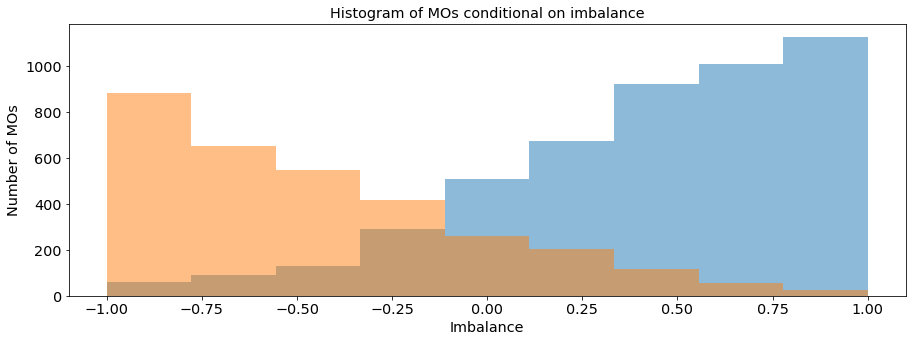

In [ ]:
#plot the number of MOs of each type that arrived when the LO imbalance was at level \rho,
#plotted as a function of \rho
plt.hist(rho_MO[MO[:,7]==-1], bins=np.linspace(-1, 1, num=10),alpha=0.5)#number of buy MOs, in blue
plt.hist(rho_MO[MO[:,7]==+1], bins=np.linspace(-1, 1, num=10),alpha=0.5)#number of sell MOs, in orange
plt.title("Histogram of MOs conditional on imbalance")
plt.xlabel(r'Imbalance')
plt.ylabel('Number of MOs')
plt.show()

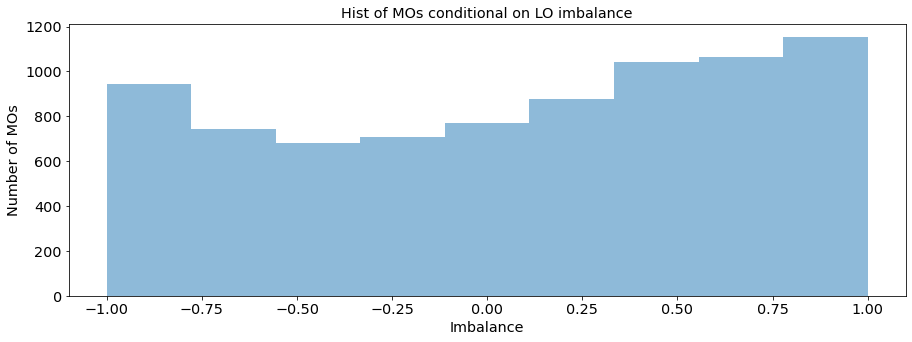

In [ ]:
#plot the number of MOs, regardless of type, that arrive when the LO imbalance 
#is at level \rho, plotted as a function of \rho
plt.hist(rho_MO, bins=np.linspace(-1, 1, num=10),alpha=0.5)
plt.title("Hist of MOs conditional on LO imbalance")
plt.xlabel(r'Imbalance')
plt.ylabel('Number of MOs')
plt.show()

In [ ]:
# determine the rate of arrival of market orders conditional on LO imbalance being in [a,b]
def MOActivity(MO,rho,a,b):
    idx_rho = (rho>=a) & (rho<b)
    idx_rho_MO = (rho_MO>=a) & (rho_MO<b)
    idx_rho_MO_b = idx_rho_MO & (MO[:,7]==-1)
    idx_rho_MO_s = idx_rho_MO & (MO[:,7]==+1)
    
    return [np.sum(idx_rho_MO_b), np.sum(idx_rho_MO_s)]/(dt*np.sum(idx_rho))

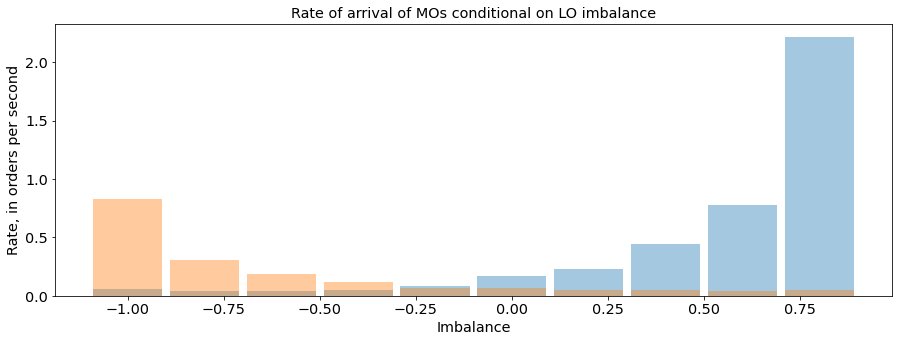

In [ ]:
nbands=10
bands = np.array([-1+2*x/(nbands) for x in range(nbands+1)])

MO_activity=np.zeros((nbands,2))
for i in range(nbands):
    MO_activity[i,:] = MOActivity(MO,rho,bands[i],bands[i+1])
MO_activity=MO_activity.T

plt.bar(bands[0:nbands],MO_activity[0,:],width=[(bands[j+1]-bands[j])*0.9 for j in range(nbands)],alpha=0.4)
plt.bar(bands[0:nbands],MO_activity[1,:],width=[(bands[j+1]-bands[j])*0.9 for j in range(nbands)],alpha=0.4)
plt.title(r'Rate of arrival of MOs conditional on LO imbalance')
plt.xlabel(r'Imbalance')
plt.ylabel(r'Rate, in orders per second')
plt.show()
#multiplying the rate of arrival by the length of the time period, we obtain
#the conditional probability that buy/sell MO arrives when the LO imbalance
#is at a given level

# Probability of price move given LO imbalance

In [ ]:
# determine the probability of price moving down within 0.1 second, given the LO imbalance being in [a,b]
def PMoveProb(dP,imb,a,b):
    idx_imb = (imb>=a) & (imb<b)
    ctr = 0
    for i in range(len(dP)):
        if ((dP[i]<0) & (imb[i]>=a) & (imb[i]<b)):
            ctr = ctr+1
    
    return ctr/np.sum(idx_imb)

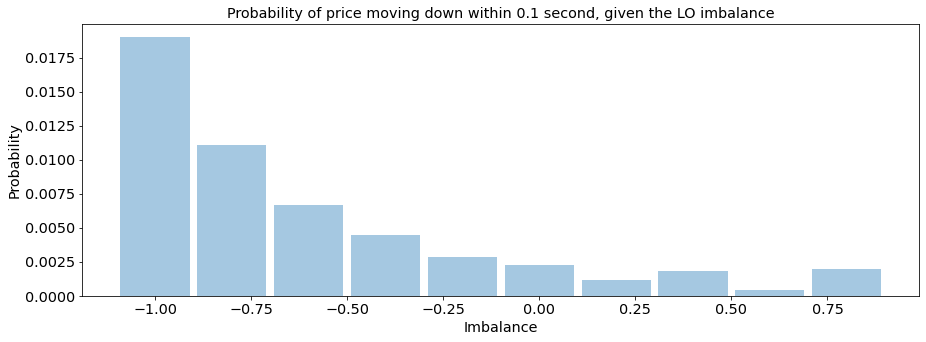

In [ ]:
nbands=10
bands = np.array([-1+2*x/(nbands) for x in range(nbands+1)])

PMove_prob=[]
Price = 0.5*(bid[:,0]+ask[:,0])
PriceDiff = np.diff(Price)
imb = rho[0:(len(rho)-1)]
for i in range(nbands):
    PMove_prob.append(PMoveProb(PriceDiff,imb,bands[i],bands[i+1]))

plt.bar(bands[0:nbands],PMove_prob,width=[(bands[j+1]-bands[j])*0.9 for j in range(nbands)],alpha=0.4)
plt.title(r'Probability of price moving down within 0.1 second, given the LO imbalance')
plt.xlabel(r'Imbalance')
plt.ylabel(r'Probability')
plt.show()